In [ ]:
#Importamos la paqueteria a usar
import pandas as pd
import numpy as np
from IPython.display import display
import datetime as dt
from google.colab import drive
import re

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

#import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Leemos los datos
#data = pd.read_excel('/content/drive/MyDrive/Elasticidades/Data/dataset_FINAL_elasticidades_nido_kinder.xlsx')
#data = pd.read_excel('/content/drive/MyDrive/Elasticidades/Data/dataset_cremadores_elasticidades.xlsx')
#data = pd.read_excel('/content/drive/MyDrive/Elasticidades/Data/Dataset_lacteos_culinarios.xlsx', sheet_name = 'all_modelado')
data = pd.read_excel('/content/drive/MyDrive/Elasticidades/Data/dataset_condimentos_liquidos_elasticidades.xlsx', sheet_name = 'MODELAR_FE')
#data = pd.read_excel('/content/drive/MyDrive/Elasticidades/Data/Dataset_Consomes.xlsx', sheet_name = 'Base_ok')

In [ ]:
#Primeros registros
display(data.head())

,ANIO,MESNUM,SEM,date,ITEM,DESCRIPCION,Promo,PesoConvertido,INGREDIENTES,TIPO,xx,SEGMENTO,MARCA,FABRICANTE,CATEGORIA,Modelado_ok,PrecioPromedio,DistribucionPonderada,DistribucionNumerica,kilos,VentasValor,VentasUnidades,kilos_dist,FE,name
0,2018,3,SEMANA 11-18,2018-03-12,41390000089,KIKKOMAN SALSA DE SOYA LIGERA LITE 148 ML 0041...,NaN,148,OTR. INGREDIENTES,SALSA DE SOYA,x,CONDIMENTOS LIQUIDOS,KIKKOMAN,KIKKOMAN,CONDIMENTO_LIQUIDO,x,59.862,0.04,0.01,11,4550,76,0.11,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148
1,2018,3,SEMANA 11-18,2018-03-12,41390000096,KIKKOMAN SALSA SOYA DOSIFICADOR 148 ML 0041390...,NaN,148,OTR. INGREDIENTES,SALSA DE SOYA,x,CONDIMENTOS LIQUIDOS,KIKKOMAN,KIKKOMAN,CONDIMENTO_LIQUIDO,x,49.959,0.05,0.02,20,6794,136,0.40,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148
2,2018,3,SEMANA 11-18,2018-03-12,41390000508,SALSA DE SOYA 148 0ML PIEZA KIKOMAN 0041390000508,NaN,148,OTR. INGREDIENTES,SALSA DE SOYA,x,CONDIMENTOS LIQUIDOS,KIKKOMAN,KIKKOMAN,CONDIMENTO_LIQUIDO,x,33.852,0.54,0.37,516,118077,3488,190.92,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148
3,2018,3,SEMANA 11-18,2018-03-12,41390000706,KIKKOMAN SALSA DE SOYA 296 ML.NAL 0041390000706,NaN,296,OTR. INGREDIENTES,SALSA DE SOYA,x,CONDIMENTOS LIQUIDOS,KIKKOMAN,KIKKOMAN,CONDIMENTO_LIQUIDO,x,51.007,0.63,0.42,1494,257503,5048,627.48,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296
4,2018,3,SEMANA 11-18,2018-03-12,41390000829,KIKKOMAN SALSA DE SOYA GLUTEN FREE BOT VID 296...,NaN,296,OTR. INGREDIENTES,SALSA DE SOYA,x,CONDIMENTOS LIQUIDOS,KIKKOMAN,KIKKOMAN,CONDIMENTO_LIQUIDO,x,74.313,0.07,0.03,39,9735,131,1.17,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296


In [ ]:
print(data.columns)

Index(['ANIO', 'MESNUM', 'SEM', 'date', 'ITEM', 'DESCRIPCION', 'Promo',
       'PesoConvertido', 'INGREDIENTES', 'TIPO', 'xx', 'SEGMENTO', 'MARCA',
       'FABRICANTE', 'CATEGORIA', 'Modelado_ok', 'PrecioPromedio',
       'DistribucionPonderada', 'DistribucionNumerica', 'kilos', 'VentasValor',
       'VentasUnidades', 'kilos_dist', 'FE', 'name'],
      dtype='object')


In [ ]:
#Quitamos los espacios a los nombres de las columnas
data.columns = [x.strip() for x in data.columns]
print(data.columns)

Index(['ANIO', 'MESNUM', 'SEM', 'date', 'ITEM', 'DESCRIPCION', 'Promo',
       'PesoConvertido', 'INGREDIENTES', 'TIPO', 'xx', 'SEGMENTO', 'MARCA',
       'FABRICANTE', 'CATEGORIA', 'Modelado_ok', 'PrecioPromedio',
       'DistribucionPonderada', 'DistribucionNumerica', 'kilos', 'VentasValor',
       'VentasUnidades', 'kilos_dist', 'FE', 'name'],
      dtype='object')


In [ ]:
#Por si Marca está pero no es la que queremos
if 'Marca' in data.columns:
  data.drop(['Marca'], axis = 1, inplace = True)

In [ ]:
#Renombramos
data.rename(columns = {
                       'FE_new':'Marca',
                       'FE':'Marca',
                       'Name 2':'Marca',
                       'unidades':'VentasUnidades',
                       'valor':'VentasValor',
                       'eq':'VentasUnidadesEQ',
                       #'kilos':'VentasKilos',
                       'date':'date_key',
                       'modelar':'Modelar',
                       'kilos_dist':'Venta_dist',
                       'kilos':'VentasUnidadesEQ'
                       }, inplace = True)
print(data.columns)

Index(['ANIO', 'MESNUM', 'SEM', 'date_key', 'ITEM', 'DESCRIPCION', 'Promo',
       'PesoConvertido', 'INGREDIENTES', 'TIPO', 'xx', 'SEGMENTO', 'MARCA',
       'FABRICANTE', 'CATEGORIA', 'Modelado_ok', 'PrecioPromedio',
       'DistribucionPonderada', 'DistribucionNumerica', 'VentasUnidadesEQ',
       'VentasValor', 'VentasUnidades', 'Venta_dist', 'Marca', 'name'],
      dtype='object')


In [ ]:
#Filtramos lo que vamos a modelar
#data = data[data['Modelar'] == 1]
data = data[data['Modelado_ok'] == 'x']

In [ ]:
#Dimensiones de la base
print("Numero de filas: ", str(data.shape[0]), "\nNumero de columnas: ", str(data.shape[1]) + "\n")

Numero de filas:  11285 
Numero de columnas:  25



In [ ]:
#Tipos de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11285 entries, 0 to 14460
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ANIO                   11285 non-null  int64         
 1   MESNUM                 11285 non-null  int64         
 2   SEM                    11285 non-null  object        
 3   date_key               11285 non-null  datetime64[ns]
 4   ITEM                   11285 non-null  int64         
 5   DESCRIPCION            11285 non-null  object        
 6   Promo                  1498 non-null   object        
 7   PesoConvertido         11285 non-null  int64         
 8   INGREDIENTES           11285 non-null  object        
 9   TIPO                   11285 non-null  object        
 10  xx                     11285 non-null  object        
 11  SEGMENTO               11285 non-null  object        
 12  MARCA                  11285 non-null  object        
 13  F

In [ ]:
#Quitamos las columnas que no ocupamos
data.drop(['xx','x1','Flag','_','name_3'], axis = 1, inplace = True, errors = 'ignore')
print("Numero de filas: ", str(data.shape[0]), "\nNumero de columnas: ", str(data.shape[1]) + "\n")

Numero de filas:  11285 
Numero de columnas:  24



In [ ]:
#Buscamos el numero de faltantes (ya no hay faltantes)
display(pd.DataFrame(data.isnull().sum()))
#data.isna().sum().plot(kind = 'bar')

,0
ANIO,0
MESNUM,0
SEM,0
date_key,0
ITEM,0
DESCRIPCION,0
Promo,9787
PesoConvertido,0
INGREDIENTES,0
TIPO,0


In [ ]:
#Valores unicos por columna
display(pd.DataFrame(data.nunique()))

,0
ANIO,4
MESNUM,12
SEM,190
date_key,190
ITEM,84
DESCRIPCION,91
Promo,1
PesoConvertido,24
INGREDIENTES,1
TIPO,5


In [ ]:
#Duplicados todas las columnas
data.duplicated().sum()

0

In [ ]:
#Creamos una llave para el periodo en caso de que no venga fecha
if 'date_key' not in data.columns:
  data['MESNUM2'] = ['0'+str(x) if x < 10 else str(x) for x in data['MESNUM']]
  data['date_key'] = data['ANIO'].astype(str) + '-' + data['MESNUM2'].astype(str) + '-' + data['SEM'].astype(str)
  data.drop(['MESNUM2'], axis = 1, inplace = True)

In [ ]:
data.columns

Index(['ANIO', 'MESNUM', 'SEM', 'date_key', 'ITEM', 'DESCRIPCION', 'Promo',
       'PesoConvertido', 'INGREDIENTES', 'TIPO', 'SEGMENTO', 'MARCA',
       'FABRICANTE', 'CATEGORIA', 'Modelado_ok', 'PrecioPromedio',
       'DistribucionPonderada', 'DistribucionNumerica', 'VentasUnidadesEQ',
       'VentasValor', 'VentasUnidades', 'Venta_dist', 'Marca', 'name'],
      dtype='object')

In [ ]:
#Duplicados ciertas columnas
data[['ITEM', 'DESCRIPCION','FABRICANTE','MARCA','Marca','ANIO','MESNUM','SEM','date_key']].duplicated().sum()

0

In [ ]:
#Agregamos el nombre del mes si no esta
if 'MES' not in data.columns:
  dict_meses = {1:'ENERO',
                2:'FEBRERO',
                3:'MARZO',
                4:'ABRIL',
                5:'MAYO',
                6:'JUNIO',
                7:'JULIO',
                8:'AGOSTO',
                9:'SEPTIEMBRE',
                10:'OCTUBRE',
                11:'NOVIEMBRE',
                12:'DICIEMBRE'}
  data['MES'] = ''
  for key, value in dict_meses.items():
    data.loc[(data.MESNUM == key), 'MES'] = value

In [ ]:
#Revisamos las ventas unidad, valor, unidades equivalentes por mes y año
dict_nombres_mes = dict(data[['MESNUM','MES']].drop_duplicates().to_dict(orient='split')['data'])
pd.options.display.float_format = '{:,}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ','Venta_dist']:
    pt = pd.pivot_table(data, values = ventas, index = ['MESNUM'], columns = ['ANIO'], aggfunc = np.sum)
    pt.rename(index = dict_nombres_mes, inplace = True)
    print(ventas.upper())
    display(pd.DataFrame(pt))
    print('\n')

VENTASUNIDADES


ANIO,2018,2019,2020,2021
MESNUM,,,,
ENERO,nan,"1,201,998.0","1,361,018.0","1,615,826.0"
FEBRERO,nan,"1,196,862.0","1,233,857.0","1,923,979.0"
MARZO,"1,025,972.0","1,517,239.0","1,959,830.0","2,255,384.0"
ABRIL,"1,100,888.0","1,267,432.0","2,022,687.0","1,509,073.0"
MAYO,"1,125,135.0","1,151,931.0","1,887,753.0","1,486,172.0"
JUNIO,"1,590,693.0","1,515,789.0","2,326,525.0","2,050,702.0"
JULIO,"1,233,063.0","1,203,849.0","1,726,911.0","1,584,241.0"
AGOSTO,"1,212,811.0","1,276,639.0","1,592,350.0","1,542,670.0"
SEPTIEMBRE,"1,463,393.0","1,497,042.0","1,906,882.0","1,893,934.0"




VENTASVALOR


ANIO,2018,2019,2020,2021
MESNUM,,,,
ENERO,nan,"39,519,318.0","45,819,401.0","57,151,994.0"
FEBRERO,nan,"39,441,645.0","41,136,613.0","61,336,979.0"
MARZO,"32,102,870.0","50,138,694.0","65,640,778.0","77,277,211.0"
ABRIL,"34,873,776.0","41,459,866.0","65,523,440.0","53,649,532.0"
MAYO,"35,836,824.0","38,632,801.0","64,508,783.0","53,095,953.0"
JUNIO,"49,282,514.0","49,758,732.0","78,319,411.0","69,517,460.0"
JULIO,"37,900,200.0","38,045,592.0","60,320,906.0","53,818,906.0"
AGOSTO,"37,299,009.0","40,945,727.0","58,232,053.0","53,523,467.0"
SEPTIEMBRE,"44,221,841.0","48,709,356.0","68,449,578.0","66,444,508.0"




VENTASUNIDADESEQ


ANIO,2018,2019,2020,2021
MESNUM,,,,
ENERO,nan,"247,586.0","274,256.0","344,840.0"
FEBRERO,nan,"247,837.0","255,152.0","367,682.0"
MARZO,"200,420.0","307,919.0","397,859.0","455,572.0"
ABRIL,"224,193.0","251,850.0","390,836.0","320,430.0"
MAYO,"229,246.0","234,026.0","383,610.0","316,644.0"
JUNIO,"311,177.0","307,132.0","467,509.0","423,369.0"
JULIO,"238,836.0","242,908.0","357,558.0","325,285.0"
AGOSTO,"240,972.0","254,823.0","336,303.0","318,285.0"
SEPTIEMBRE,"289,895.0","295,838.0","390,700.0","395,493.0"




VENTA_DIST


ANIO,2018,2019,2020,2021
MESNUM,,,,
ENERO,nan,"137,646.79","165,484.28000000014","215,546.04999999993"
FEBRERO,nan,"141,475.07000000007","152,531.17000000004","225,210.90000000002"
MARZO,"117,205.97999999998","176,368.91999999987","242,044.5899999999","290,516.2900000003"
ABRIL,"125,462.88","145,659.11","238,436.22000000003","203,682.29999999996"
MAYO,"130,004.2600000001","132,002.34000000003","234,007.07999999984","198,274.4899999999"
JUNIO,"177,064.72999999992","173,451.04000000007","275,547.7500000001","263,915.8700000001"
JULIO,"133,171.81999999995","137,055.01999999996","214,823.68","203,125.62000000002"
AGOSTO,"134,789.35000000003","149,546.56999999998","201,389.23","197,065.75999999992"
SEPTIEMBRE,"158,707.19999999998","176,160.84000000003","237,019.5599999999","245,101.35000000012"


VENTASUNIDADES


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
NESTLE,"9,679,601.0","12,023,076.0","16,455,604.0","12,892,996.0"
SALSAS CASTILLO,"1,416,225.0","1,817,207.0","2,653,588.0","2,235,594.0"
HERDEZ,nan,nan,"1,684,282.0","1,246,278.0"
PANAMERICANA OCC.,"519,267.0","592,098.0","724,758.0","512,621.0"
LEE KUM KEE,"177,898.0","277,699.0","382,862.0","299,816.0"
LEA & PERRINS,"110,204.0","141,725.0","181,449.0","76,352.0"
KIKKOMAN,"860,881.0","1,098,386.0",nan,nan


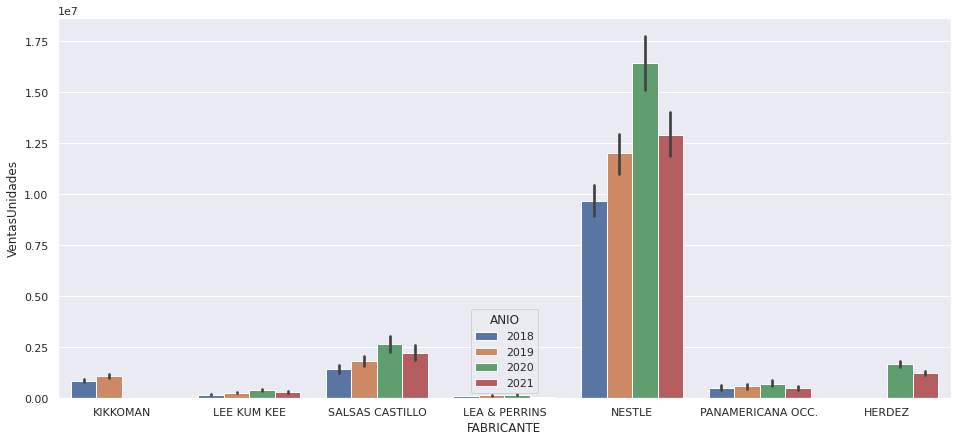



VENTASVALOR


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
NESTLE,"302,600,538.0","393,316,343.0","555,487,315.0","437,471,725.0"
HERDEZ,nan,nan,"99,701,511.0","77,680,270.0"
SALSAS CASTILLO,"26,245,051.0","36,441,386.0","54,502,205.0","47,294,540.0"
LEE KUM KEE,"9,777,908.0","15,125,484.0","21,907,722.0","19,786,396.0"
PANAMERICANA OCC.,"8,044,311.0","9,793,522.0","12,376,645.0","9,144,577.0"
LEA & PERRINS,"5,827,240.0","7,873,083.0","10,854,384.0","4,200,919.0"
KIKKOMAN,"44,746,898.0","61,910,753.0",nan,nan


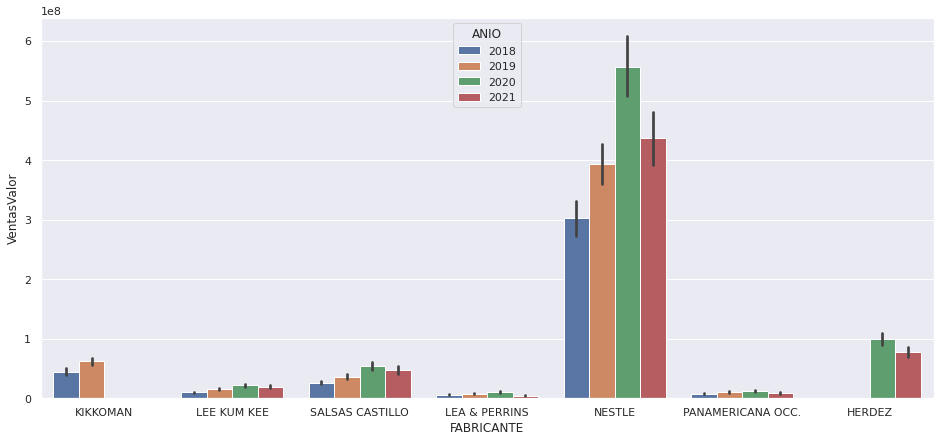



VENTASUNIDADESEQ


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
NESTLE,"1,559,267.0","1,951,015.0","2,626,150.0","2,092,868.0"
SALSAS CASTILLO,"547,706.0","707,924.0","1,060,298.0","918,941.0"
HERDEZ,nan,nan,"403,528.0","294,697.0"
LEE KUM KEE,"83,010.0","129,527.0","175,564.0","137,593.0"
PANAMERICANA OCC.,"106,259.0","120,988.0","147,446.0","110,463.0"
LEA & PERRINS,"26,184.0","33,930.0","45,446.0","15,176.0"
KIKKOMAN,"204,579.0","262,833.0",nan,nan


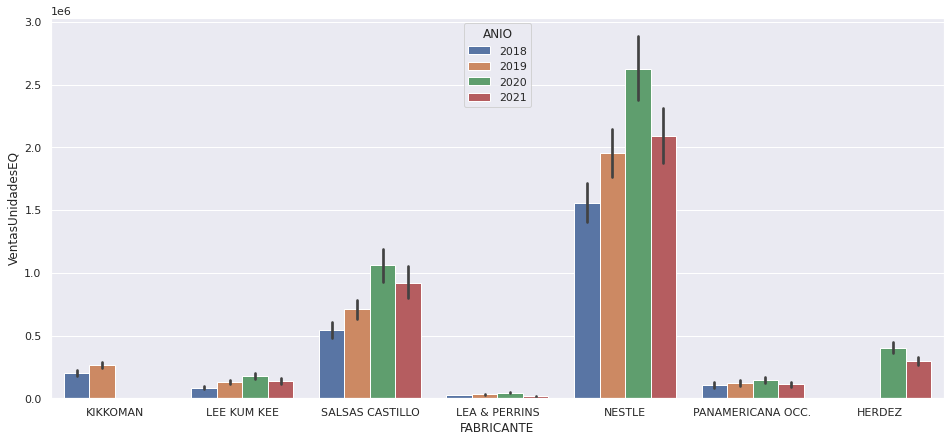



VENTA_DIST


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
NESTLE,"1,163,460.76","1,490,989.5300000007","2,063,936.650000001","1,666,472.1199999978"
SALSAS CASTILLO,"149,141.41","233,451.8699999999","445,618.13999999996","414,127.47000000003"
HERDEZ,nan,nan,"123,696.57000000012","88,172.77000000002"
PANAMERICANA OCC.,"36,495.77000000002","37,022.59000000001","48,839.52000000002","36,190.860000000015"
LEE KUM KEE,"12,621.14999999999","20,936.620000000024","27,620.649999999976","20,536.209999999995"
LEA & PERRINS,"4,138.259999999999","5,808.2699999999995","8,575.189999999999","1,573.270000000001"
KIKKOMAN,"60,717.38","77,355.24000000002",nan,nan


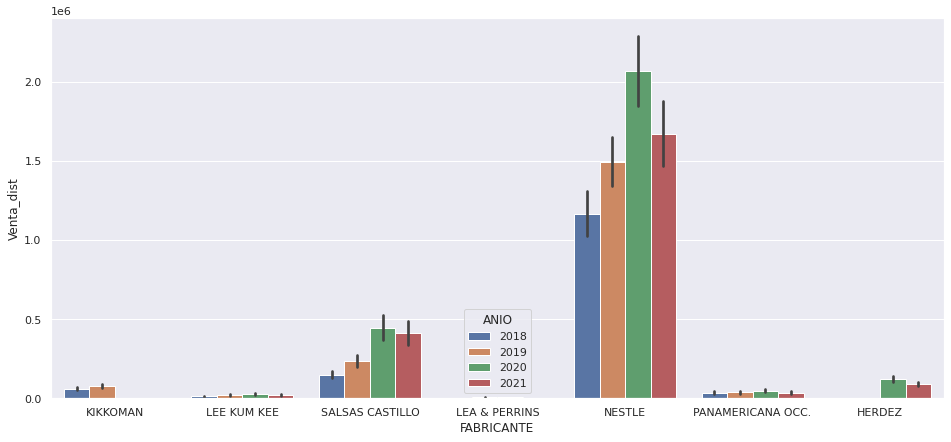

In [ ]:
#Revisamos las ventas unidad, valor, unidades equivalentes por fabricante y año
pd.options.display.float_format = '{:,}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ','Venta_dist']:
    pt = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['FABRICANTE'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    print(ventas.upper())
    display(pt)
    fig, ax = plt.subplots(figsize=(16,7))
    sns.barplot(data = data, x = 'FABRICANTE', y=ventas, hue='ANIO', estimator = np.sum, ax = ax)
    plt.show()
    print('\n')

2018


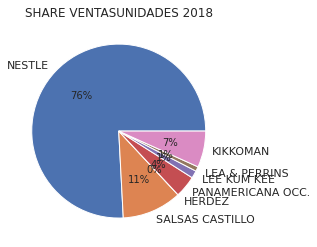

2019


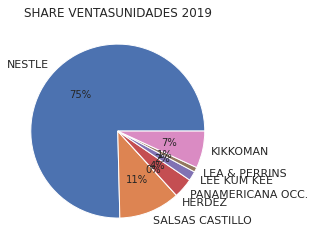

2020


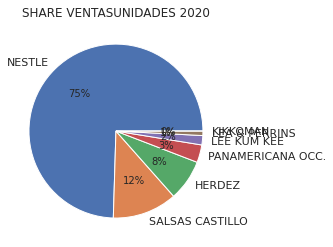

2021


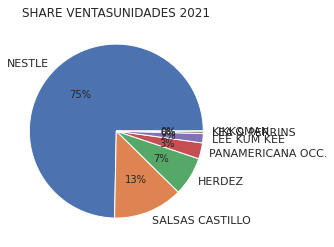

VENTASUNIDADES


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
NESTLE,%75.83,%75.38,%74.52,%74.68
SALSAS CASTILLO,%11.10,%11.39,%12.02,%12.95
HERDEZ,%0.00,%0.00,%7.63,%7.22
PANAMERICANA OCC.,%4.07,%3.71,%3.28,%2.97
LEE KUM KEE,%1.39,%1.74,%1.73,%1.74
LEA & PERRINS,%0.86,%0.89,%0.82,%0.44
KIKKOMAN,%6.74,%6.89,%0.00,%0.00




2018


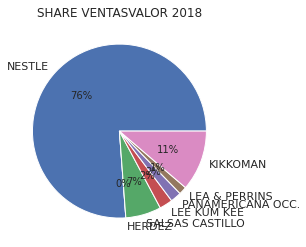

2019


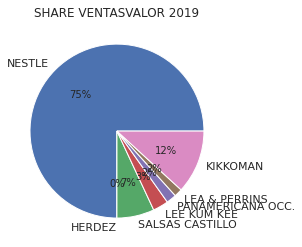

2020


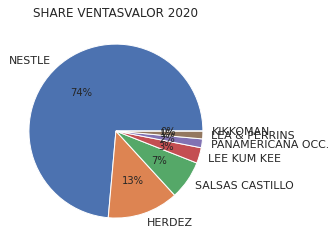

2021


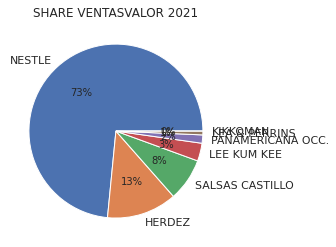

VENTASVALOR


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
NESTLE,%76.18,%74.99,%73.59,%73.45
HERDEZ,%0.00,%0.00,%13.21,%13.04
SALSAS CASTILLO,%6.61,%6.95,%7.22,%7.94
LEE KUM KEE,%2.46,%2.88,%2.90,%3.32
PANAMERICANA OCC.,%2.03,%1.87,%1.64,%1.54
LEA & PERRINS,%1.47,%1.50,%1.44,%0.71
KIKKOMAN,%11.26,%11.80,%0.00,%0.00




2018


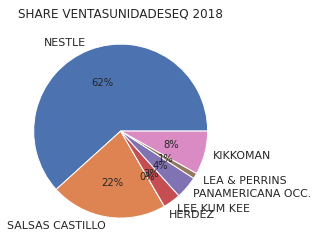

2019


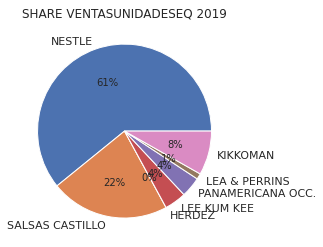

2020


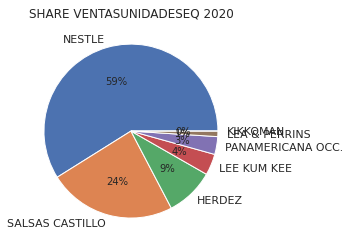

2021


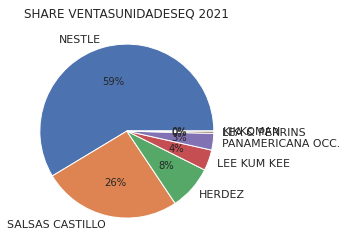

VENTASUNIDADESEQ


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
NESTLE,%61.70,%60.85,%58.90,%58.63
SALSAS CASTILLO,%21.67,%22.08,%23.78,%25.74
HERDEZ,%0.00,%0.00,%9.05,%8.26
LEE KUM KEE,%3.28,%4.04,%3.94,%3.85
PANAMERICANA OCC.,%4.20,%3.77,%3.31,%3.09
LEA & PERRINS,%1.04,%1.06,%1.02,%0.43
KIKKOMAN,%8.10,%8.20,%0.00,%0.00




2018


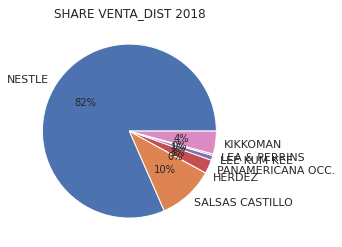

2019


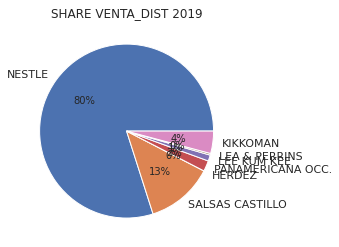

2020


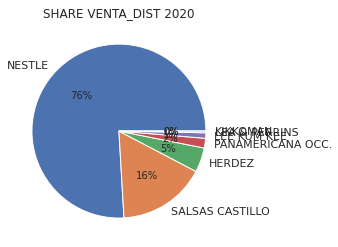

2021


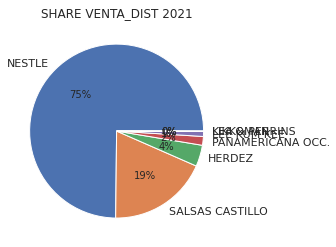

VENTA_DIST


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
NESTLE,%81.56,%79.92,%75.93,%74.83
SALSAS CASTILLO,%10.45,%12.51,%16.39,%18.60
HERDEZ,%0.00,%0.00,%4.55,%3.96
PANAMERICANA OCC.,%2.56,%1.98,%1.80,%1.63
LEE KUM KEE,%0.88,%1.12,%1.02,%0.92
LEA & PERRINS,%0.29,%0.31,%0.32,%0.07
KIKKOMAN,%4.26,%4.15,%0.00,%0.00


In [ ]:
#Revisamos el share anual de las ventas unidad, valor, unidades equivalentes por marca y año
pd.options.display.float_format = '%{:.2f}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ','Venta_dist']:
    pt = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['FABRICANTE'], columns = ['ANIO'], aggfunc = np.sum, fill_value = 0)).sort_values(2021, ascending = False, na_position = 'last')
    pt_sum = pt.sum()
    for col in np.sort(data['ANIO'].unique()):
        print(col)
        pt[col] = (pt[col] / pt_sum[col]) * 100
        plt.pie(pt[col], labels = pt.index, autopct='%.0f%%')
        plt.title("SHARE " + ventas.upper() + ' ' + str(col))
        plt.show()
    print(ventas.upper())
    display(pd.DataFrame(pt))
    print('\n')

In [ ]:
#Revisamos el precio promedio anual y el precio promedio eq por FE
pd.options.display.float_format = '${:.2f}'.format
for ventas in ['VentasUnidades','VentasUnidadesEQ','Venta_dist']:
    pt_unid = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['FABRICANTE'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_valor = pd.DataFrame(pd.pivot_table(data, values = 'VentasValor', index = ['FABRICANTE'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_valor = pt_valor.div(pt_unid, axis = 1, fill_value=0)
    #for col in [2018,2019,2020,2021]:
    #    pt[col] = (pt[col] / pt_sum[col]) * 100
    print(ventas.upper())
    display(pd.DataFrame(pt_valor))
    print('\n')

VENTASUNIDADES


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
HERDEZ,$nan,$nan,$59.20,$62.33
KIKKOMAN,$51.98,$56.37,$nan,$nan
LEA & PERRINS,$52.88,$55.55,$59.82,$55.02
LEE KUM KEE,$54.96,$54.47,$57.22,$66.00
NESTLE,$31.26,$32.71,$33.76,$33.93
PANAMERICANA OCC.,$15.49,$16.54,$17.08,$17.84
SALSAS CASTILLO,$18.53,$20.05,$20.54,$21.16




VENTASUNIDADESEQ


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
HERDEZ,$nan,$nan,$247.07,$263.59
KIKKOMAN,$218.73,$235.55,$nan,$nan
LEA & PERRINS,$222.55,$232.04,$238.84,$276.81
LEE KUM KEE,$117.79,$116.77,$124.78,$143.80
NESTLE,$194.07,$201.60,$211.52,$209.03
PANAMERICANA OCC.,$75.70,$80.95,$83.94,$82.78
SALSAS CASTILLO,$47.92,$51.48,$51.40,$51.47




VENTA_DIST


ANIO,2018,2019,2020,2021
FABRICANTE,,,,
HERDEZ,$nan,$nan,$806.02,$881.00
KIKKOMAN,$736.97,$800.34,$nan,$nan
LEA & PERRINS,$1408.14,$1355.50,$1265.79,$2670.18
LEE KUM KEE,$774.72,$722.44,$793.16,$963.49
NESTLE,$260.09,$263.80,$269.14,$262.51
PANAMERICANA OCC.,$220.42,$264.53,$253.41,$252.68
SALSAS CASTILLO,$175.97,$156.10,$122.31,$114.20


In [ ]:
#Revisamos las ventas unidad, valor, unidades equivalentes por FE_new
pd.options.display.float_format = '{:,.1f}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ','Venta_dist']:
    pt = pd.pivot_table(data, values = ventas, index = ['Marca'], columns = ['ANIO'], aggfunc = np.sum).sort_values(2021, ascending = False, na_position = 'last')
    print(ventas.upper())
    display(pd.DataFrame(pt))
    print('\n')

VENTASUNIDADES


ANIO,2018,2019,2020,2021
Marca,,,,
Maggi Jugo 100Ml,2291256,2783691,3769443,2917856
C&B Inglesa 145Ml,1171839,1677625,2776658,2199765
Maggi Soya 290Ml,1383662,1717423,2380960,2105426
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,965094,1288957,2062713,1764380
Maggi Jugo 200Ml,1163846,1427480,1897504,1550388
Maggi Jugo 45Ml,1144402,1513076,1629950,1085999
C&B Inglesa 290Ml,961393,1164665,1469385,1070323
C&B Inglesa 50Ml,354345,160290,864173,882606
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,472192,610156,957415,685355




VENTASVALOR


ANIO,2018,2019,2020,2021
Marca,,,,
Maggi Jugo 100Ml,67031242,85586336,121232588,97255812
Maggi Jugo 200Ml,63275437,79986202,112973652,92527198
C&B Inglesa 145Ml,34081324,52431935,90120757,74049834
C&B Inglesa 290Ml,52694121,65505767,86535810,66232036
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,28781924,40200655,65659599,50649449
Maggi Soya 290Ml,29962665,39443367,57428403,47911437
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,16415337,23825522,38574822,33594166
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,13542982,18405263,29625981,24140385
Maggi Jugo 45Ml,16259170,22262418,27174352,19562924




VENTASUNIDADESEQ


ANIO,2018,2019,2020,2021
Marca,,,,
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,342609,457580,732263,626353
Maggi Soya 290Ml,401260,498055,690479,610572
C&B Inglesa 145Ml,169918,243259,397994,318949
C&B Inglesa 290Ml,278806,337754,420144,310383
Maggi Jugo 200Ml,231885,285321,379496,310076
Maggi Jugo 100Ml,238389,285828,382907,299473
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,161679,201304,281654,261063
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,139768,180613,283400,202859
LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,71734,108946,147128,112640




VENTA_DIST


ANIO,2018,2019,2020,2021
Marca,,,,
Maggi Soya 290Ml,"350,063.9","438,172.3","630,602.5","564,565.4"
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,"106,774.5","176,297.3","371,597.6","340,801.5"
C&B Inglesa 145Ml,"106,551.7","183,895.2","360,886.6","296,617.1"
Maggi Jugo 200Ml,"197,983.1","242,445.0","313,888.4","252,987.4"
Maggi Jugo 100Ml,"184,453.6","237,330.1","321,477.1","251,726.6"
C&B Inglesa 290Ml,"221,277.8","262,341.9","303,778.8","220,847.3"
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,"33,904.8","47,876.4","65,693.6","67,653.3"
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,"46,526.0","59,790.8","97,751.8","67,466.7"
PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,"34,703.7","35,290.1","46,978.4","33,808.9"


In [ ]:
#Revisamos el share anual de las ventas unidad, valor, unidades equivalentes por FE
pd.options.display.float_format = '%{:.2f}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ','Venta_dist']:
    pt = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['Marca'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_sum = pt.sum()
    for col in np.sort(data['ANIO'].unique()):
        pt[col] = (pt[col] / pt_sum[col]) * 100
    print(ventas.upper())
    display(pd.DataFrame(pt))
    print('\n')

VENTASUNIDADES


ANIO,2018,2019,2020,2021
Marca,,,,
Maggi Jugo 100Ml,%17.95,%17.45,%17.07,%16.90
C&B Inglesa 145Ml,%9.18,%10.52,%12.57,%12.74
Maggi Soya 290Ml,%10.84,%10.77,%10.78,%12.20
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,%7.56,%8.08,%9.34,%10.22
Maggi Jugo 200Ml,%9.12,%8.95,%8.59,%8.98
Maggi Jugo 45Ml,%8.97,%9.49,%7.38,%6.29
C&B Inglesa 290Ml,%7.53,%7.30,%6.65,%6.20
C&B Inglesa 50Ml,%2.78,%1.00,%3.91,%5.11
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,%3.70,%3.83,%4.34,%3.97




VENTASVALOR


ANIO,2018,2019,2020,2021
Marca,,,,
Maggi Jugo 100Ml,%16.87,%16.32,%16.06,%16.33
Maggi Jugo 200Ml,%15.93,%15.25,%14.97,%15.54
C&B Inglesa 145Ml,%8.58,%10.00,%11.94,%12.43
C&B Inglesa 290Ml,%13.26,%12.49,%11.46,%11.12
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,%7.25,%7.67,%8.70,%8.50
Maggi Soya 290Ml,%7.54,%7.52,%7.61,%8.04
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,%4.13,%4.54,%5.11,%5.64
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,%3.41,%3.51,%3.92,%4.05
Maggi Jugo 45Ml,%4.09,%4.24,%3.60,%3.28




VENTASUNIDADESEQ


ANIO,2018,2019,2020,2021
Marca,,,,
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,%13.56,%14.27,%16.42,%17.55
Maggi Soya 290Ml,%15.88,%15.53,%15.49,%17.10
C&B Inglesa 145Ml,%6.72,%7.59,%8.93,%8.93
C&B Inglesa 290Ml,%11.03,%10.53,%9.42,%8.69
Maggi Jugo 200Ml,%9.18,%8.90,%8.51,%8.69
Maggi Jugo 100Ml,%9.43,%8.91,%8.59,%8.39
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,%6.40,%6.28,%6.32,%7.31
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,%5.53,%5.63,%6.36,%5.68
LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,%2.84,%3.40,%3.30,%3.16




VENTA_DIST


ANIO,2018,2019,2020,2021
Marca,,,,
Maggi Soya 290Ml,%24.54,%23.49,%23.20,%25.35
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,%7.48,%9.45,%13.67,%15.30
C&B Inglesa 145Ml,%7.47,%9.86,%13.28,%13.32
Maggi Jugo 200Ml,%13.88,%13.00,%11.55,%11.36
Maggi Jugo 100Ml,%12.93,%12.72,%11.83,%11.30
C&B Inglesa 290Ml,%15.51,%14.06,%11.18,%9.92
PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,%2.38,%2.57,%2.42,%3.04
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,%3.26,%3.20,%3.60,%3.03
PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,%2.43,%1.89,%1.73,%1.52


In [ ]:
#Revisamos el precio promedio anual y el precio promedio eq por FE
pd.options.display.float_format = '${:.2f}'.format
for ventas in ['VentasUnidades','VentasUnidadesEQ','Venta_dist']:
    pt_unid = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['Marca'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_valor = pd.DataFrame(pd.pivot_table(data, values = 'VentasValor', index = ['Marca'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_valor = pt_valor.div(pt_unid, axis = 1, fill_value = 0)
    #for col in [2018,2019,2020,2021]:
    #    pt[col] = (pt[col] / pt_sum[col]) * 100
    print(ventas.upper())
    display(pd.DataFrame(pt_valor))
    print('\n')

VENTASUNIDADES


ANIO,2018,2019,2020,2021
Marca,,,,
C&B Inglesa 145Ml,$29.08,$31.25,$32.46,$33.66
C&B Inglesa 290Ml,$54.81,$56.24,$58.89,$61.88
C&B Inglesa 50Ml,$12.86,$14.05,$11.31,$11.75
C&B Inglesa 980Ml,$118.33,$113.32,$124.90,$132.42
KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,$62.04,$64.72,$69.41,$73.24
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,$38.69,$42.01,$44.57,$46.10
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,$156.78,$157.51,$173.24,$187.39
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,$60.95,$65.89,$68.58,$73.90
LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,$38.19,$39.41,$40.87,$43.26




VENTASUNIDADESEQ


ANIO,2018,2019,2020,2021
Marca,,,,
C&B Inglesa 145Ml,$200.58,$215.54,$226.44,$232.17
C&B Inglesa 290Ml,$189.00,$193.95,$205.97,$213.39
C&B Inglesa 50Ml,$257.19,$280.95,$235.10,$246.13
C&B Inglesa 980Ml,$121.08,$115.55,$127.49,$135.05
KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,$190.33,$198.51,$212.90,$224.66
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,$261.43,$283.88,$301.19,$311.47
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,$83.22,$83.40,$91.64,$99.29
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,$205.93,$222.58,$231.69,$249.68
LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,$268.91,$277.49,$287.82,$304.57




VENTA_DIST


ANIO,2018,2019,2020,2021
Marca,,,,
C&B Inglesa 145Ml,$319.86,$285.12,$249.72,$249.65
C&B Inglesa 290Ml,$238.14,$249.70,$284.86,$299.90
C&B Inglesa 50Ml,$958.01,$2346.21,$1912.77,$2357.81
C&B Inglesa 980Ml,$13037.09,$12937.53,$13156.35,$13504.67
KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,$1169.90,$1206.31,$1232.87,$1788.35
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,$1114.01,$1234.20,$1317.08,$1256.06
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,$inf,$inf,$64471.76,$15558.01
KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,$618.62,$672.36,$671.70,$750.73
LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,$2552.19,$2554.73,$2952.26,$3407.51


In [ ]:
#Revision
#pd.options.display.float_format = '{:.2f}'.format
#pt_nido_sistema21 = pd.DataFrame(pd.pivot_table(data[data['FE_new']=='Nido Sistema 2.1Kg'], values = ['unidades','valor','eq'], index = ['ANIO'], aggfunc = np.sum))
#pt_nido_sistema21['FC'] = pt_nido_sistema21['eq'] / pt_nido_sistema21['unidades']
#display(pt_nido_sistema21)

In [ ]:
#Quitamos FE que no se van a modelar
#data.drop(data[data.FE_new.isin(['Nido Sistema miel y Cereales 460G','Nido Sistema 2.1Kg'])].index, inplace = True)

In [ ]:
#Manejo de NA's (Aparentemente se dejan de vender pero necesitamos la info)
#Tablas con las ventas por uni eq y valor por periodo y marca
#Quitamos los indices dependiendo el metodo a usar de imputacion
VU_EQ = pd.DataFrame(pd.pivot_table(data, values = ['VentasUnidades'], index = ['date_key'], columns = ['Marca'], aggfunc = np.sum))
#VU_EQ.to_csv('VU_EQ_LC.csv')
VU_EQ_ind = VU_EQ.index
VU_EQ.reset_index(inplace = True, drop = True)
VU_Val = pd.DataFrame(pd.pivot_table(data, values = ['VentasValor'], index = ['date_key'], columns = ['Marca'], aggfunc = np.sum))
#VU_Val.to_csv('VU_Val_LC.csv')
VU_Val_ind = VU_Val.index
VU_Val.reset_index(inplace = True, drop = True)
VU_Dist = pd.DataFrame(pd.pivot_table(data, values = ['Venta_dist'], index = ['date_key'], columns = ['Marca'], aggfunc = np.sum))
VU_Dist.to_csv('VU_Dist_LC.csv')
VU_Dist_ind = VU_Dist.index
VU_Dist.reset_index(inplace = True, drop = True)

#Ordenamos columnas
VU_EQ.sort_index(axis = 1, inplace = True)
VU_Val.sort_index(axis = 1, inplace = True)
VU_Dist.sort_index(axis = 1, inplace = True)

#Modificamos el nombre de las columnas
VU_EQ.columns = VU_EQ.columns.get_level_values(1)
VU_Val.columns = VU_Val.columns.get_level_values(1)
VU_Dist.columns = VU_Dist.columns.get_level_values(1)

#Imputamos los faltantes con el minimo
for col in VU_EQ.columns:
    VU_EQ[[col]] = VU_EQ[[col]].fillna(value = VU_EQ[[col]].min())         #Imputamos con el minimo (1)
    VU_Val[[col]] = VU_Val[[col]].fillna(value = VU_Val[[col]].min())      #Imputamos con el minimo (1)
    VU_Dist[[col]] = VU_Dist[[col]].fillna(value = VU_Dist[[col]].min())   #Imputamos con el minimo (1)

#Imputamos con arboles de regresion multi
#estim = ExtraTreesRegressor(n_estimators = 50, random_state = 42)
#Imp = IterativeImputer(estimator = estim, min_value = 1, random_state = 42)
#VU_EQ.to_csv('VU_EQ_Antes.csv', index = False)
#VU_EQ_imp = Imp.fit_transform(VU_EQ)
#VU_EQ = pd.DataFrame(data = VU_EQ_imp, index = VU_EQ_ind, columns = VU_EQ.columns)
#VU_Val_imp = Imp.fit_transform(VU_Val)
#VU_Val = pd.DataFrame(data = VU_Val_imp, index = VU_Val_ind, columns = VU_Val.columns)
#VU_EQ.to_csv('VU_EQ_Despues.csv', index = False)

#Imputamos con KNN
#Imp_KNN = KNNImputer(n_neighbors = 3, weights = 'distance')
#VU_EQ_imp = Imp_KNN.fit_transform(VU_EQ)
#VU_EQ = pd.DataFrame(data = VU_EQ_imp, index = VU_EQ_ind, columns = VU_EQ.columns)
#VU_EQ.to_csv('VU_EQ_Despues.csv', index = False)

#Ponemos los indices de nuevo
VU_EQ['date_key'] = VU_EQ_ind
VU_EQ.set_index('date_key', inplace = True)
VU_Val['date_key'] = VU_Val_ind
VU_Val.set_index('date_key', inplace = True)
VU_Dist['date_key'] = VU_Dist_ind
VU_Dist.set_index('date_key', inplace = True)

#Agrupamos los datos
VU_EQ = VU_EQ.stack().reset_index()
VU_EQ.columns = ['date_key','Marca','VentasUnidades']
VU_Val = VU_Val.stack().reset_index()
VU_Val.columns = ['date_key','Marca','VentasValor']
VU_Dist = VU_Dist.stack().reset_index()
VU_Dist.columns = ['date_key','Marca','Venta_dist']

#Juntamos las bases
acum = VU_EQ.merge(VU_Val, on = ['date_key','Marca']).merge(VU_Dist, on = ['date_key','Marca'])
acum['VentasUnidades'] = acum['VentasUnidades'].astype(int)
#acum['Venta_dist'] = acum['Venta_dist'].astype(int)
acum.loc[acum['VentasUnidades'] == 0, 'VentasUnidades'] = 1
acum.loc[acum['Venta_dist'] == 0, 'Venta_dist'] = 0.1
#acum.loc[acum['VentasValor'] == 0, 'VentasValor'] = 1
acum['precio'] = acum['VentasValor'] / acum['VentasUnidades']
try:
  acum['ANIO'] = [int(x[:4]) for x in acum['date_key']]
except:
  acum['ANIO'] = acum['date_key'].dt.year
display(acum.head())
print(acum.shape)

,date_key,Marca,VentasUnidades,VentasValor,Venta_dist,precio,ANIO
0,2018-03-12,C&B Inglesa 145Ml,26284,783143,$2400.93,$29.80,2018
1,2018-03-12,C&B Inglesa 290Ml,22464,1234839,$5146.85,$54.97,2018
2,2018-03-12,C&B Inglesa 50Ml,11881,177838,$172.26,$14.97,2018
3,2018-03-12,C&B Inglesa 980Ml,45,5234,$0.44,$116.31,2018
4,2018-03-12,KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF...,901,55012,$47.04,$61.06,2018


(5510, 7)


In [ ]:
#Quitamos los FE que no vamos a modelar
#Marcas a quitar cremadores
acum = acum[~acum['Marca'].isin(['Coffee Mate Lite 311G','Coffee Mate 4g','Coffee Mate Stick 34G','Coffee Mate Liq Sab I&O 500Ml'])]
acum = acum[~acum['Marca'].isin(['CORINA_POLVO_BOTE_454','CREMORA_POLVO_BOTE_1000','CREMORA_POLVO_BOTE_170'])]

#acum = acum[~acum['Marca'].isin(['COFFEE MATE_POLVO_DOY PACK_226','COFFEE MATE_POLVO_FRASCO_1000','COFFEE MATE_POLVO_BOLSA_250','COFFEE MATE_POLVO_BOTE_226',
#                                 'COFFEE MATE_POLVO_BOTE_453','COFFEE MATE_POLVO_SOBRE_250','COFFEE MATE_POLVO_SOBRE_36','COFFEE MATE_POLVO_LATA_400',
#                                 'COFFEE MATE_LIQUIDO_BOTE_473','COFFEE MATE_POLVO_BOTE_420','COFFEE MATE_POLVO_SOBRE_40','COFFEE MATE_POLVO_BOTE_520',
#                                 'COFFEE MATE_POLVO_DOY PACK_227','COFFEE MATE_POLVO_DOY PACK_220','COFFEE MATE_POLVO_BOTE_170','COFFEE MATE_LIQUIDO_CARTON_500',
#                                 'COFFEE MATE_POLVO_BOTE_210','COFFEE MATE_POLVO_LATA_1200','COFFEE MATE_POLVO_LATA_900'])]
#Marcas a quitar nido
acum = acum[~acum['Marca'].isin(['Nido Forti 1.92Kg', 'Nido Forti 360G', 'Nido Deslac 800G', 'Nido Forti 1.56Kg', 'Nido Forti 2.28 Kg', 
                                 'Nido Sistema 144G ', 'Nido Sistema miel y Cereales 460G', 'Nido Sistema 2.1Kg'])]

#Marcas a quitar sazonadores
acum = acum[~acum['Marca'].isin(['C&B Inglesa 50Ml', 'LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_284', 'Maggi Jugo Reducida'])]

#Marcas a quitar lacteos culinarios
#acum = acum[~acum['Marca'].isin([])]

In [ ]:
#Creamos una base para generar los modelos
#pd.options.display.float_format = '{:,.1f}'.format
#acum = pd.DataFrame(data.groupby(['Marca','date_key'])['VentasUnidades','VentasValor'].agg([np.sum])).reset_index().sort_values(['Marca','date_key'])
#acum.columns = acum.columns.get_level_values(0)
#acum.loc[acum['VentasUnidades'] == 0, 'VentasUnidades'] = 1
#acum['precio'] = acum['VentasValor'] / acum['VentasUnidades']
#display(acum.head())
#print(acum.shape)
#Quitamos los FE que no vamos a modelar
#acum = acum[~acum['FE_new'].isin(['Nido Forti 1.56Kg','Nido Deslac 800G','Nido Forti 1.92Kg','Nido Forti 2.28 Kg','Nido Forti 360G','Nido Sistema 144G '])]

In [ ]:
acum.to_csv('Acumulado.csv', index=False)

In [ ]:
##Regresiones lineales (log) con intercepto por FE
resultados = {'FEs' : list(acum.Marca.unique()),
              'f_pvalue' : [],
              'r2' : [],
              'r2_adj' : []}
betas = {}
for FE in resultados['FEs']:
    #Preparamos los datos a usar
    sub = acum[acum['Marca'] == FE]
    sub = sub[['date_key','Venta_dist']].sort_values('date_key')
    precios_pt = pd.pivot_table(acum[['date_key','Marca','precio']], values = 'precio', index = ['date_key'],columns = ['Marca'], aggfunc = np.sum)
    precios_pt.columns = precios_pt.columns.get_level_values(0)
    precios_pt.columns = ['PR_' + x for x in precios_pt.columns]
    #Imputamos el precio con la mediana
    for p in precios_pt.columns:
      precios_pt[[p]] = precios_pt[[p]].fillna(value = precios_pt[[p]].median())
    sub = sub.merge(precios_pt, how = 'left', on = 'date_key', sort = True)
    aux = sub.drop(['date_key'], axis = 1).apply(np.log, axis = 0).copy()#dropna()
    aux['t'] = range(0, aux.shape[0])
    y = aux['Venta_dist'].copy()
    X = aux.drop(['Venta_dist'], axis = 1).copy()
    display(X)
    display(y)
    #Modelamos
    model = sm.OLS(y, sm.add_constant(X)).fit()
    betas[FE] = model.params.reset_index().rename(columns = {'index':'type',0:'parameter'})
    #Guardamos el modelo
    model_name = FE + '.sav'
    pickle.dump(model, open(model_name, 'wb'))
    #Guardamos estadisticos
    resultados['f_pvalue'].append(model.f_pvalue)
    resultados['r2'].append(model.rsquared_adj)
    resultados['r2_adj'].append(model.rsquared)
    print('-'*100)
    print('Elasticidad ' + FE)
    print(model.summary())
    #Graficamos
    print('-'*100)

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $7.78
1     $7.82
2     $8.22
3     $7.80
4     $7.77
       ... 
185   $8.89
186   $8.73
187   $8.79
188   $8.66
189   $8.79
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad C&B Inglesa 145Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     55.14
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           6.83e-68
Time:                        17:32:10   Log-Likelihood:                 86.876
No. Observations:                 190   AIC:                            -117.8
Df Residuals:                     162   BIC:                            -26.83
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $8.55
1     $8.63
2     $9.01
3     $8.50
4     $8.49
       ... 
185   $8.52
186   $8.38
187   $8.45
188   $8.33
189   $8.42
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad C&B Inglesa 290Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     3.808
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           5.56e-08
Time:                        17:32:11   Log-Likelihood:                 79.048
No. Observations:                 190   AIC:                            -102.1
Df Residuals:                     162   BIC:                            -11.18
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $-0.82
1     $-0.92
2     $-0.67
3     $-0.94
4     $-0.94
       ...  
185    $0.04
186   $-0.05
187    $0.21
188    $0.04
189   $-0.16
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad C&B Inglesa 980Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     6.851
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           8.07e-16
Time:                        17:32:11   Log-Likelihood:                -116.88
No. Observations:                 190   AIC:                             289.8
Df Residuals:                     162   BIC:                             380.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $3.85
1     $3.81
2     $3.80
3     $3.86
4     $3.93
       ... 
185   $3.42
186   $3.37
187   $3.45
188   $3.46
189   $3.51
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     11.30
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.35e-25
Time:                        17:32:11   Log-Likelihood:                 3.4781
No. Observations:                 190   AIC:                             49.04
Df Residuals:                     162   BIC:                             140.0
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                             

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $5.65
1     $5.62
2     $5.89
3     $5.63
4     $5.68
       ... 
185   $6.11
186   $6.04
187   $6.04
188   $5.91
189   $5.89
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     20.87
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           9.12e-40
Time:                        17:32:11   Log-Likelihood:                 131.52
No. Observations:                 190   AIC:                            -207.0
Df Residuals:                     162   BIC:                            -116.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $-2.30
1     $-2.30
2     $-2.30
3     $-2.30
4     $-2.30
       ...  
185   $-0.63
186   $-0.19
187   $-0.71
188   $-0.24
189   $-0.51
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     6.604
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.14e-15
Time:                        17:32:11   Log-Likelihood:                -124.91
No. Observations:                 190   AIC:                             305.8
Df Residuals:                     162   BIC:                             396.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $7.00
1     $7.03
2     $7.14
3     $6.99
4     $7.02
       ... 
185   $7.38
186   $7.33
187   $7.38
188   $7.31
189   $7.32
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     20.37
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.91e-39
Time:                        17:32:12   Log-Likelihood:                 114.53
No. Observations:                 190   AIC:                            -173.1
Df Residuals:                     162   BIC:                            -82.15
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $2.10
1     $2.26
2     $2.83
3     $2.60
4     $2.33
       ... 
185   $2.73
186   $2.73
187   $2.57
188   $2.53
189   $2.68
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     4.480
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           8.24e-10
Time:                        17:32:12   Log-Likelihood:                 47.125
No. Observations:                 190   AIC:                            -38.25
Df Residuals:                     162   BIC:                             52.67
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                            

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $1.30
1     $1.55
2     $1.62
3     $1.44
4     $2.43
       ... 
185   $3.20
186   $3.03
187   $3.18
188   $3.02
189   $2.94
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     29.64
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           2.42e-49
Time:                        17:32:12   Log-Likelihood:                 20.896
No. Observations:                 190   AIC:                             14.21
Df Residuals:                     162   BIC:                             105.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                          

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $0.25
1     $0.42
2     $0.39
3     $0.65
4     $0.39
       ... 
185   $1.44
186   $1.58
187   $1.68
188   $1.49
189   $1.47
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     47.10
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           5.08e-63
Time:                        17:32:12   Log-Likelihood:                 46.226
No. Observations:                 190   AIC:                            -36.45
Df Residuals:                     162   BIC:                             54.47
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                              

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $-0.29
1     $-0.58
2      $0.02
3     $-0.04
4     $-0.11
       ...  
185    $0.59
186    $0.69
187    $0.71
188    $0.63
189    $0.65
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     19.89
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           1.61e-38
Time:                        17:32:13   Log-Likelihood:                -17.831
No. Observations:                 190   AIC:                             91.66
Df Residuals:                     162   BIC:                             182.6
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                              

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $5.66
1     $5.61
2     $5.76
3     $5.71
4     $5.73
       ... 
185   $5.88
186   $5.82
187   $5.86
188   $5.75
189   $5.56
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     15.84
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           7.71e-33
Time:                        17:32:13   Log-Likelihood:                 112.04
No. Observations:                 190   AIC:                            -168.1
Df Residuals:                     162   BIC:                            -77.15
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                              

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $6.01
1     $6.07
2     $6.77
3     $5.92
4     $5.86
       ... 
185   $5.15
186   $5.06
187   $4.92
188   $4.86
189   $4.95
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Cocktail
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     12.45
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           2.76e-27
Time:                        17:32:13   Log-Likelihood:                 32.096
No. Observations:                 190   AIC:                            -8.191
Df Residuals:                     162   BIC:                             82.73
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err   

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $6.64
1     $6.71
2     $7.37
3     $6.69
4     $6.64
       ... 
185   $5.61
186   $5.48
187   $5.44
188   $5.22
189   $5.37
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Inglesa 100 Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     13.81
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           1.27e-29
Time:                        17:32:13   Log-Likelihood:                 16.079
No. Observations:                 190   AIC:                             23.84
Df Residuals:                     162   BIC:                             114.8
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $8.32
1     $8.35
2     $8.79
3     $8.29
4     $8.27
       ... 
185   $8.68
186   $8.55
187   $8.59
188   $8.48
189   $8.59
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Jugo 100Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     10.57
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           8.34e-24
Time:                        17:32:13   Log-Likelihood:                 114.53
No. Observations:                 190   AIC:                            -173.1
Df Residuals:                     162   BIC:                            -82.15
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $8.42
1     $8.47
2     $8.90
3     $8.40
4     $8.39
       ... 
185   $8.62
186   $8.52
187   $8.55
188   $8.45
189   $8.54
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Jugo 200Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     9.065
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           9.04e-21
Time:                        17:32:14   Log-Likelihood:                 101.21
No. Observations:                 190   AIC:                            -146.4
Df Residuals:                     162   BIC:                            -55.50
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $6.34
1     $6.34
2     $6.80
3     $6.28
4     $6.27
       ... 
185   $6.18
186   $6.05
187   $6.12
188   $5.97
189   $6.07
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Jugo 45Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     6.557
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           4.08e-15
Time:                        17:32:14   Log-Likelihood:                 73.477
No. Observations:                 190   AIC:                            -90.95
Df Residuals:                     162   BIC:                          -0.03757
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err  

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $-1.47
1     $-1.24
2     $-0.67
3     $-1.17
4     $-1.20
       ...  
185   $-0.27
186   $-0.25
187   $-0.24
188   $-0.12
189   $-0.40
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Jugo 800Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     8.589
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           9.33e-20
Time:                        17:32:14   Log-Likelihood:                -108.37
No. Observations:                 190   AIC:                             272.7
Df Residuals:                     162   BIC:                             363.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $3.60
1     $3.75
2     $4.47
3     $4.13
4     $4.05
       ... 
185   $5.29
186   $5.17
187   $5.19
188   $5.08
189   $5.12
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Soya 140Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     17.65
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           1.75e-35
Time:                        17:32:14   Log-Likelihood:                -17.752
No. Observations:                 190   AIC:                             91.50
Df Residuals:                     162   BIC:                             182.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $5.20
1     $5.28
2     $5.71
3     $5.27
4     $5.36
       ... 
185   $4.28
186   $4.04
187   $4.25
188   $4.01
189   $3.90
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Soya 200Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     29.69
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           2.20e-49
Time:                        17:32:14   Log-Likelihood:                 50.286
No. Observations:                 190   AIC:                            -44.57
Df Residuals:                     162   BIC:                             46.34
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $9.09
1     $9.05
2     $9.34
3     $9.05
4     $9.02
       ... 
185   $9.46
186   $9.33
187   $9.40
188   $9.29
189   $9.34
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad Maggi Soya 290Ml
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     27.44
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.60e-47
Time:                        17:32:15   Log-Likelihood:                 161.06
No. Observations:                 190   AIC:                            -266.1
Df Residuals:                     162   BIC:                            -175.2
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err 

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $6.70
1     $6.69
2     $6.94
3     $6.67
4     $6.73
       ... 
185   $6.70
186   $6.57
187   $6.65
188   $6.51
189   $6.51
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     10.48
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           1.23e-23
Time:                        17:32:15   Log-Likelihood:                 162.35
No. Observations:                 190   AIC:                            -268.7
Df Residuals:                     162   BIC:                            -177.8
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                     

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $3.34
1     $3.42
2     $3.39
3     $3.35
4     $3.44
       ... 
185   $4.28
186   $4.18
187   $4.25
188   $4.18
189   $4.18
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     19.90
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           1.57e-38
Time:                        17:32:15   Log-Likelihood:                 86.811
No. Observations:                 190   AIC:                            -117.6
Df Residuals:                     162   BIC:                            -26.71
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                     

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $6.69
1     $6.76
2     $7.04
3     $6.71
4     $6.81
       ... 
185   $7.44
186   $7.38
187   $7.42
188   $7.23
189   $7.30
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     36.20
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           4.08e-55
Time:                        17:32:15   Log-Likelihood:                 156.12
No. Observations:                 190   AIC:                            -256.2
Df Residuals:                     162   BIC:                            -165.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                   

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $5.35
1     $5.37
2     $5.76
3     $5.54
4     $5.29
       ... 
185   $5.07
186   $4.98
187   $4.90
188   $4.59
189   $4.77
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     22.71
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           5.36e-42
Time:                        17:32:16   Log-Likelihood:                 162.31
No. Observations:                 190   AIC:                            -268.6
Df Residuals:                     162   BIC:                            -177.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                    

,PR_C&B Inglesa 145Ml,PR_C&B Inglesa 290Ml,PR_C&B Inglesa 980Ml,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._326,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,PR_KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,PR_LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLESA_142,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF._480,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_250,PR_LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_Maggi Cocktail,PR_Maggi Inglesa 100 Ml,PR_Maggi Jugo 100Ml,PR_Maggi Jugo 200Ml,PR_Maggi Jugo 45Ml,PR_Maggi Jugo 800Ml,PR_Maggi Soya 140Ml,PR_Maggi Soya 200Ml,PR_Maggi Soya 290Ml,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_175,PR_PASA_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_500,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1000,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_150,PR_PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355,t
0,$3.39,$4.01,$4.76,$4.11,$3.69,$5.01,$4.09,$3.57,$3.87,$3.98,$4.20,$4.03,$3.13,$3.27,$3.42,$4.00,$2.75,$5.16,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.55,$2.77,0
1,$3.39,$4.00,$4.75,$4.11,$3.69,$4.97,$4.10,$3.58,$3.87,$3.98,$4.21,$4.03,$3.14,$3.25,$3.42,$3.99,$2.75,$5.15,$2.77,$3.29,$3.09,$2.66,$3.42,$3.62,$2.55,$2.75,1
2,$3.38,$3.99,$4.75,$4.11,$3.68,$5.04,$4.08,$3.58,$3.90,$3.94,$4.14,$4.02,$3.10,$3.25,$3.41,$3.98,$2.74,$5.15,$2.80,$3.30,$3.09,$2.66,$3.42,$3.58,$2.54,$2.83,2
3,$3.37,$4.01,$4.75,$4.13,$3.68,$5.04,$4.12,$3.59,$3.87,$3.94,$4.18,$4.03,$3.10,$3.25,$3.41,$3.99,$2.75,$5.15,$2.81,$3.30,$3.09,$2.66,$3.42,$3.62,$2.49,$2.82,3
4,$3.35,$4.01,$4.75,$4.12,$3.68,$5.04,$4.13,$3.59,$3.67,$3.96,$4.18,$4.04,$3.12,$3.26,$3.40,$4.00,$2.75,$5.11,$2.82,$3.28,$3.09,$2.65,$3.42,$3.62,$2.56,$2.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,$3.50,$4.13,$4.90,$4.33,$3.87,$5.23,$4.33,$3.78,$4.09,$4.37,$4.58,$4.18,$3.24,$3.37,$3.50,$4.12,$2.89,$5.12,$2.83,$3.43,$3.19,$2.76,$3.48,$3.67,$2.69,$2.97,185
186,$3.52,$4.12,$4.87,$4.32,$3.87,$5.23,$4.33,$3.80,$4.08,$4.25,$4.52,$4.17,$3.25,$3.38,$3.50,$4.12,$2.89,$5.10,$2.83,$3.47,$3.19,$2.76,$3.49,$3.67,$2.68,$2.97,186
187,$3.50,$4.11,$4.84,$4.32,$3.87,$5.24,$4.32,$3.82,$4.08,$4.30,$4.59,$4.15,$3.27,$3.42,$3.48,$4.11,$2.89,$5.08,$2.82,$3.43,$3.18,$2.76,$3.48,$3.67,$2.75,$2.94,187
188,$3.49,$4.11,$4.84,$4.29,$3.87,$5.22,$4.31,$3.83,$4.09,$4.29,$4.58,$4.16,$3.27,$3.42,$3.48,$4.10,$2.89,$5.09,$2.82,$3.44,$3.18,$2.77,$3.48,$3.69,$2.75,$2.93,188


0     $7.94
1     $7.88
2     $7.98
3     $7.73
4     $7.80
       ... 
185   $9.04
186   $8.91
187   $9.06
188   $9.00
189   $8.98
Name: Venta_dist, Length: 190, dtype: float64

----------------------------------------------------------------------------------------------------
Elasticidad PEKIN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_355
                            OLS Regression Results                            
Dep. Variable:             Venta_dist   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     126.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           9.54e-95
Time:                        17:32:16   Log-Likelihood:                 145.64
No. Observations:                 190   AIC:                            -235.3
Df Residuals:                     162   BIC:                            -144.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                    

In [ ]:
#Cuadro resumen
pd.options.display.float_format = '{:,.4f}'.format
resume = pd.DataFrame.from_dict(resultados)
resume.to_csv('Resumen_Modelos.csv', index = False)
display(resume)

,FEs,f_pvalue,r2,r2_adj
0,C&B Inglesa 145Ml,0.0000,0.8855,0.9019
1,C&B Inglesa 290Ml,0.0000,0.2863,0.3882
2,C&B Inglesa 980Ml,0.0000,0.4553,0.5331
3,KIKKOMAN_CONDIMENTOS LIQUIDOS_OTHERS TIPO UNIF...,0.0000,0.5954,0.6532
4,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_148,0.0000,0.7395,0.7767
5,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_1890,0.0000,0.4446,0.5240
6,KIKKOMAN_CONDIMENTOS LIQUIDOS_SALSA DE SOYA_296,0.0000,0.7345,0.7725
7,LEA & PERRINS_CONDIMENTOS LIQUIDOS_SALSA INGLE...,0.0000,0.3321,0.4275
8,LEE KUM KEE_CONDIMENTOS LIQUIDOS_OTHERS TIPO U...,0.0000,0.8036,0.8317
9,LEE KUM KEE_CONDIMENTOS LIQUIDOS_SALSA DE SOYA...,0.0000,0.8682,0.8870


In [ ]:
# Compilamos las betas en un DataFrame
betas_comp = pd.concat(betas).reset_index().drop('level_1', axis = 1).rename(columns={'level_0':'model'})
display(betas_comp)

In [ ]:
# Pivotal con las betas por modelo y precio
elasticidades_cruzadas = pd.pivot_table(betas_comp, index = 'model', columns = 'type', values = 'parameter').copy()
elasticidades_cruzadas.drop(['const','t'], axis = 1, inplace = True, errors = 'ignore')
elasticidades_cruzadas.to_csv('Elasticidades_Cruzadas.csv')
display(elasticidades_cruzadas)
#print(elasticidades_cruzadas.columns)

In [ ]:
#Graficamos las elasticidades cruzadas en un heatmap
fig, ax = plt.subplots(figsize=(20,12))
hm = sns.heatmap(data = elasticidades_cruzadas, yticklabels = elasticidades_cruzadas.index, xticklabels = elasticidades_cruzadas.columns, 
                 cmap = sns.color_palette('magma', as_cmap=True), annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Elasticidades cruzadas')
plt.ylabel('Demanda EQ')
plt.xlabel('Precio')
plt.show()
fig = hm.get_figure()
fig.savefig('Elasticidades cruzadas.png')

In [ ]:
def X_predecir(FE, var_ini = -50, var_fin = 50, var_tam = 1, intercepto = True, delta_sem = 1, sem_prom = 3, FES_mod = []):
  #Las variables 'var' son ´porcentajes y deben ser enteros
  #Generamos el ultimo registro del X de entrenamiento
  sub = acum[(acum['Marca'] == FE) & (acum['ANIO'] == 2021)]
  sub = sub[['date_key','Venta_dist']]
  sub = pd.DataFrame(sub.mean(axis = 0)).reset_index(drop = True)
  sub.rename(columns = {0:'Venta_dist'}, inplace = True)
  aux = acum[['date_key','Marca','precio']]
  t_actual = len(acum['date_key'].unique())
  #Filtramos por el numero de periodos maximos a promediar
  lista_prom = sorted(acum['date_key'].unique())[-sem_prom:]
  aux = acum[acum['date_key'].isin(lista_prom)]
  #Preparamos el insumo de precios
  precios_pt = pd.pivot_table(aux[['date_key','Marca','precio']], values = 'precio', index = ['date_key'], columns = ['Marca'], aggfunc = np.sum)
  precios_pt.columns = precios_pt.columns.get_level_values(0)
  precios_pt = pd.DataFrame(precios_pt.mean(axis = 0), index = precios_pt.columns).transpose()
  #precios_pt.sort_index(inplace = True)
  precios_pt.columns = ['PR_' + x for x in precios_pt.columns]
  precio_eq_inicial = precios_pt['PR_' + FE][0]
  #sub = sub.merge(precios_pt, how = 'left', on = 'date_key', sort = True)
  sub = pd.concat([sub.reset_index(drop = True), precios_pt], axis = 1)
  X = sub.drop(['Venta_dist'], axis = 1).copy()
  #Generamos los factores disponibles
  list_var = list(np.arange(var_ini, var_fin + var_tam, var_tam))
  pct_cambio = [1 + (x / 100) for x in list_var]
  pct_cambio.sort()
  #Armamos el DF en el que van a estar los casos a revisar
  X_acum = pd.DataFrame()
  for i in range(0, len(pct_cambio)):
    X_acum = X_acum.append(X, ignore_index = True)
  #Modificamos los precios de las marcas a modificar el precio
  if FE not in FES_mod:
    FES_mod.append(FE)
  #Modificamos los precios de las marcas a considerar
  for m in FES_mod:
    precio_inicial = X['PR_' + m][0]
    list_precios = [precio_inicial * x for x in pct_cambio]
    X_acum['PR_' + m] = list_precios
  #precio_inicial = X['PR_' + FE][0]
  #list_precios = [precio_inicial * x for x in pct_cambio]
  #X_acum['PR_' + FE] = list_precios
  #Aplicamos logaritmos
  X_acum = X_acum.apply(np.log, axis = 0).copy()
  X_acum['t'] = t_actual + delta_sem - 1
  #Si es necesario agregar el intercepto
  if intercepto == True:
    X_acum = sm.add_constant(X_acum, has_constant = 'add')
  X_acum['VAR'] = list_var
  X_acum.set_index('VAR', inplace = True)
  return X_acum, precio_eq_inicial

In [ ]:
X_predecir('Maggi Soya 290Ml', var_ini = 1, var_fin = 2, var_tam = .5, intercepto = True, delta_sem = 1, FES_mod = [])

In [ ]:
print(acum['Marca'].unique())

In [ ]:
X_test, p_inicial = X_predecir(FE = 'Maggi Jugo 100Ml', var_ini = 10, var_fin = 11, var_tam = 0.5, FES_mod = ['Maggi Jugo 200Ml'])
display(X_test.head())
print(p_inicial)

In [ ]:
#Funcion que calcula la sabana de demanda considerando todas las marcas y un DF de variaciones de precio
#Puede devolver {'Unidades EQ', 'Valor', 'Unidad', 'Dist'}
def Sabana_Demanda(X, val = 'Dist'):
  demanda = pd.DataFrame()
  marcas = acum['Marca'].unique()
  for FE in marcas:
    model_name = FE + '.sav'
    model = pickle.load(open(model_name, 'rb'))
    demanda[FE] = model.predict(X)
  demanda = demanda.apply(np.exp, axis = 0).copy()
  if val == 'Valor':
    precios = X.drop(columns = ['const','t'])
    precios.columns = [x[3:] for x in precios.columns]
    precios = precios.apply(np.exp, axis = 0).copy()
    demanda = demanda.mul(precios)
  elif val == 'Unidad':
    marca_propia = data[data['Marca'] == 'controlled_label_creamers']
    imp_mc = sum(marca_propia['VentasUnidadesEQ']) / sum(marca_propia['VentasUnidades'])
    #Catalogo de factores de conversion
    catalogo_conv = pd.DataFrame(data = {'Marca':acum['Marca'].unique()})
    catalogo_conv['FC'] = [int(re.search('\d+', x)[0]) / 1000 if x != 'controlled_label_creamers' else imp_mc for x in catalogo_conv['Marca']]
    catalogo_conv.set_index('Marca', inplace = True)
    for x in demanda.columns:
      demanda[x] = demanda[x] / catalogo_conv.loc[x, 'FC']
  return demanda

In [ ]:
demanda = Sabana_Demanda(X_test, val = 'Dist')
display(demanda)

In [ ]:
#Funcion que grafica la sabana de demanda estimada de una sola marca
#sns.set_theme(style='whitegrid')
def Grafica_Demanda_Marginal(demanda, FE, list_precio, guardar = False):
  fig, ax = plt.subplots(figsize=(15,7))
  axes = [ax, ax.twinx()] #Copiamos el eje
  fig.subplots_adjust(right=0.80) #Hacemos espacio a la derecha
  axes[-1].spines['right'].set_position(('axes', 1)) #Ponemos el ultimo eje copiado a la derecha
  axes[-1].set_frame_on(True)
  axes[-1].patch.set_visible(False)
  dem_sim = sns.lineplot(data = demanda[FE], ax = axes[0], color = 'black')
  axes[1].scatter(x = demanda.index, y = list_precio, alpha = 0.5, c = list_precio)
  plt.title('Demanda simulada ' + FE)
  plt.xlabel('Variacion de precio')
  plt.ylabel('Demanda estimada')
  plt.show()
  if guardar == True:
    fig.savefig('Demanda_Sim_' + FE + '.png')

In [ ]:
Grafica_Demanda_Marginal(demanda = demanda, FE = 'Maggi Jugo 100Ml', list_precio = np.exp(X_test['PR_Maggi Inglesa 100 Ml']), guardar = False)

###Escenario de precios
Queremos explorar que pasa si incrementamos \\
5%, 5.5% y 6%

In [ ]:
# Extraemos las marcas a utilizar
marcas_sazonadores = data[(data['FABRICANTE'] == 'NESTLE') & (data['Marca'].isin(acum['Marca']))]
marcas_sazonadores = list(marcas_sazonadores['Marca'].unique())
print(marcas_sazonadores)

#Para la presentación polvo

### Demandas marginales

In [ ]:
# Demandas con variaciones marginales para polvo
sazonador_marginal = {'Marca':[],
                  'Precio_Base':[],
                  'Demanda_Sazonador_Dist_50':[],
                  'Demanda_Sazonador_Dist_55':[],
                  'Demanda_Sazonador_Dist_60':[],
                  'Precio_Sazonador_Dist_50':[],
                  'Precio_Sazonador_Dist_55':[],
                  'Precio_Sazonador_Dist_60':[]}
for marca in marcas_sazonadores:
  print(marca)
  X, pr_inicial = X_predecir(marca, var_ini = 5, var_fin = 6, var_tam = 0.5, intercepto = True, delta_sem = 1, FES_mod = [])
  demanda = Sabana_Demanda(X)
  display(demanda)
  Grafica_Demanda_Marginal(demanda = demanda, FE = marca, list_precio = np.exp(X['PR_' + marca]), guardar = False)
  #Guardamos los datos a entregar
  sazonador_marginal['Marca'].append(marca)
  sazonador_marginal['Precio_Base'].append(pr_inicial)
  sazonador_marginal['Demanda_Sazonador_Dist_50'].append(demanda[marca][5])
  sazonador_marginal['Demanda_Sazonador_Dist_55'].append(demanda[marca][5.5])
  sazonador_marginal['Demanda_Sazonador_Dist_60'].append(demanda[marca][6])
  sazonador_marginal['Precio_Sazonador_Dist_50'].append(np.exp(X['PR_' + marca][5]))
  sazonador_marginal['Precio_Sazonador_Dist_55'].append(np.exp(X['PR_' + marca][5.5]))
  sazonador_marginal['Precio_Sazonador_Dist_60'].append(np.exp(X['PR_' + marca][6]))
sazonador_marginal = pd.DataFrame(sazonador_marginal)

### Demandas conjuntas

In [ ]:
# Demandas con variaciones conjuntas para polvo
sazonador_conjunto = {'Marca':[],
                  'Precio_Base':[],
                  'Demanda_Sazonador_Dist_50':[],
                  'Demanda_Sazonador_Dist_55':[],
                  'Demanda_Sazonador_Dist_60':[],
                  'Precio_Sazonador_Dist_50':[],
                  'Precio_Sazonador_Dist_55':[],
                  'Precio_Sazonador_Dist_60':[]}
marcas_sazonadores_it = marcas_sazonadores.copy()
for marca in marcas_sazonadores_it:
  print(marca)
  X, pr_inicial = X_predecir(FE = marca, var_ini = 5, var_fin = 6, var_tam = 0.5, intercepto = True, delta_sem = 1, FES_mod = marcas_sazonadores.copy())
  demanda = Sabana_Demanda(X)
  display(demanda)
  Grafica_Demanda_Marginal(demanda = demanda, FE = marca, list_precio = np.exp(X['PR_' + marca]), guardar = False)
  #Guardamos los datos a entregar
  sazonador_conjunto['Marca'].append(marca)
  sazonador_conjunto['Precio_Base'].append(pr_inicial)
  sazonador_conjunto['Demanda_Sazonador_Dist_50'].append(demanda[marca][5])
  sazonador_conjunto['Demanda_Sazonador_Dist_55'].append(demanda[marca][5.5])
  sazonador_conjunto['Demanda_Sazonador_Dist_60'].append(demanda[marca][6])
  sazonador_conjunto['Precio_Sazonador_Dist_50'].append(np.exp(X['PR_' + marca][5]))
  sazonador_conjunto['Precio_Sazonador_Dist_55'].append(np.exp(X['PR_' + marca][5.5]))
  sazonador_conjunto['Precio_Sazonador_Dist_60'].append(np.exp(X['PR_' + marca][6]))
sazonador_conjunto = pd.DataFrame(sazonador_conjunto)

In [ ]:
#Preparamos la base del output
base = data[data['ANIO'] == 2021].copy()
num_base = len(base['date_key'].unique())
base = base.groupby(['Marca'])['VentasValor', 'VentasUnidades', 'VentasUnidadesEQ','Venta_dist'].agg([np.sum]).reset_index()
base.columns = base.columns.get_level_values(0)
for x in base.select_dtypes(exclude = ['object']).columns:
  base[x] = base[x] / num_base
print(base.info())

#Creamos el dataframe de las marginales
base_marginal = base.merge(sazonador_marginal, how = 'outer', on = 'Marca')
#base_marginal['Precio_Base_x'] = base_marginal['Precio_Base_x'].combine_first(base_marginal['Precio_Base_y'])
#Consideramos solo las marcas que se modelaron
base_marginal = base_marginal[~base_marginal['Precio_Base'].isna()]
#base_marginal.drop(['Precio_Base_y'], axis = 1, inplace = True)
#ase_marginal.rename(columns = {'Precio_Base_x':'Precio_Base'}, inplace = True)
base_marginal.to_csv('Base_Marginal.csv', index=False)

#Creamos el dataframe de las conjuntas
base_conjunta = base.merge(sazonador_conjunto, how = 'outer', on = 'Marca')
#base_conjunta = base_conjunta.merge(liquido_conjunto, how = 'outer', on = 'Marca')
#base_conjunta['Precio_Base_x'] = base_conjunta['Precio_Base_x'].combine_first(base_conjunta['Precio_Base_y'])
#Consideramos solo las marcas que se modelaron
base_conjunta = base_conjunta[~base_conjunta['Precio_Base'].isna()]
#base_conjunta.drop(['Precio_Base_y'], axis = 1, inplace = True)
#base_conjunta.rename(columns = {'Precio_Base_x':'Precio_Base'}, inplace = True)
base_conjunta.to_csv('Base_Conjunta.csv', index=False)
display(base_conjunta)

In [ ]:
#Grafica de las correlaciones
correlaciones = demanda.corr()
fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(data = correlaciones, yticklabels = correlaciones.index, 
            xticklabels = correlaciones.columns, annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Correlaciones')
plt.xlabel("Precio")
plt.ylabel("Ventas")
plt.show()

In [ ]:
#Correlaciones
correlaciones = pd.pivot_table(acum, values = ['Venta_dist','precio'], index = 'date_key', columns = 'Marca')
correlaciones = correlaciones.corr(method = 'spearman')

correlaciones.drop('Venta_dist', level = 0, inplace = True)
correlaciones.drop('precio', level = 0, axis = 1, inplace = True)

fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(data = correlaciones, yticklabels = correlaciones.columns.get_level_values(1), 
            xticklabels = correlaciones.index.get_level_values(1), annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Correlaciones')
plt.xlabel("Precio")
plt.ylabel("Ventas")
plt.show()

In [ ]:
#Correlaciones ventas ponderadas
correlaciones = pd.pivot_table(acum, values = ['Venta_dist'], index = 'date_key', columns = 'Marca')
correlaciones = correlaciones.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(data = correlaciones, yticklabels = correlaciones.columns.get_level_values(1), 
            xticklabels = correlaciones.index.get_level_values(1), annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Correlaciones ventas unidad eq')
plt.xlabel("Ventas unidad por marca")
plt.ylabel("Ventas unidad por marca")
plt.show()

In [ ]:
# VIF Si hay mucha multicolinealidad en todo :(
dic_vif = {}
for FE in resultados['FEs']:
    #Preparamos los datos a usar
    sub = acum[acum['Marca'] == FE]
    sub = sub[['date_key','Venta_dist']]
    precios_pt = pd.pivot_table(acum[['date_key','Marca','precio']], values='precio', index=['date_key'],columns=['Marca'], aggfunc=np.sum)
    precios_pt.columns = precios_pt.columns.get_level_values(0)
    precios_pt.columns = ['PR_' + x for x in precios_pt.columns]
    sub = sub.merge(precios_pt, how = 'left', on = 'date_key', sort = True)
    aux = sub.drop(['date_key'], axis = 1).apply(np.log, axis = 0).copy()#dropna()
    aux['t'] = range(0, aux.shape[0])
    y = aux['Venta_dist'].copy()
    X = aux.drop(['Venta_dist'], axis = 1).copy()
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
    dic_vif[FE] = vif_data
display(dic_vif)

In [ ]:
#Correlaciones ventas por precio
correlaciones = pd.pivot_table(acum, values = ['precio'], index = 'date_key', columns = 'Marca')
correlaciones = correlaciones.corr(method='spearman')

fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(data = correlaciones, yticklabels = correlaciones.columns.get_level_values(1), 
            xticklabels = correlaciones.index.get_level_values(1), annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Correlaciones ventas kilo')
plt.xlabel("Precio marca")
plt.ylabel("Precio marca")
plt.show()

In [ ]:
#Graficamos las demandas de las marcas en un heatmap
fig, ax = plt.subplots(figsize=(20,20))
hm = sns.heatmap(data = demanda, yticklabels = demanda.index, xticklabels = demanda.columns,
                 cmap = sns.color_palette('magma', as_cmap=True), ax = ax)
plt.title('Demanda simulada')
plt.xlabel('Marca')
plt.ylabel('Variacion precio')
plt.show()
#fig = hm.get_figure()
#fig.savefig('Elasticidades cruzadas.png')